In [ ]:
import pandas as pd

In [ ]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None,
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)

    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index,
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();

    return fig, ax

In [ ]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d,
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags,
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [ ]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5),
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},
                  annotate_seas=False, m = None,
                 seas_color='black'):

    fig, axes = plt.subplots(nrows=2, figsize=figsize)


    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)

    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)

    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)




    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)

        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()

    return fig

In [ ]:
url= "https://docs.google.com/spreadsheets/d/e/2PACX-1vQN3Ksa9szQuO4G1-msXWAp17KtVHQCBnuEieu_auu1wSiBf3-krHusIx5VBMkihxj-KZLBosDIGEyR/pub?output=csv"
df= pd.read_csv(url)

In [ ]:
dataframe= pd.DataFrame(df)
dataframe

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0
4,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,114794.0,114975.0,...,269323.0,274032.0,278464.0,284127.0,289739.0,294776.0,297727.0,298796.0,299124.0,298951.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22462,236350,28439,Palisades,city,TX,TX,"Amarillo, TX",Randall County,NaN,NaN,...,198490.0,198467.0,196420.0,192002.0,191634.0,189383.0,191134.0,191343.0,192384.0,192110.0
22463,40403,28439,Port Mansfield,city,TX,TX,"Raymondville, TX",Willacy County,NaN,NaN,...,229251.0,232984.0,238245.0,240154.0,242470.0,243119.0,249098.0,255572.0,261910.0,264685.0
22464,54740,28439,Tribes Hill,city,NY,NY,"Amsterdam, NY",Montgomery County,53380.0,53662.0,...,132490.0,134951.0,137470.0,137430.0,137413.0,137615.0,138908.0,140096.0,141573.0,142438.0
22465,249186,28439,Derby Center,city,VT,VT,NaN,Orleans County,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,258191.0,261607.0,264571.0,266255.0


In [ ]:
#dataframe['RegionID']= dataframe['RegionID'].drop_duplicates()

In [ ]:
id_cols = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'CountyName']

melted = pd.melt(df, id_vars=id_cols, value_name="Typical Home Value", var_name='Month')
melted

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,Month,Typical Home Value
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-01-31,253690.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,2000-01-31,234181.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,2000-01-31,109068.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,2000-01-31,166139.0
4,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,2000-01-31,114794.0
...,...,...,...,...,...,...,...,...,...,...
6133486,236350,28439,Palisades,city,TX,TX,"Amarillo, TX",Randall County,2022-09-30,192110.0
6133487,40403,28439,Port Mansfield,city,TX,TX,"Raymondville, TX",Willacy County,2022-09-30,264685.0
6133488,54740,28439,Tribes Hill,city,NY,NY,"Amsterdam, NY",Montgomery County,2022-09-30,142438.0
6133489,249186,28439,Derby Center,city,VT,VT,NaN,Orleans County,2022-09-30,266255.0


In [ ]:
melted['Month'] = pd.to_datetime(melted['Month'])
melted = melted.set_index("Month")
melted

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,Typical Home Value
Month,,,,,,,,,
2000-01-31,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0
2000-01-31,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0
2000-01-31,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0
2000-01-31,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0
2000-01-31,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,114794.0
...,...,...,...,...,...,...,...,...,...
2022-09-30,236350,28439,Palisades,city,TX,TX,"Amarillo, TX",Randall County,192110.0
2022-09-30,40403,28439,Port Mansfield,city,TX,TX,"Raymondville, TX",Willacy County,264685.0
2022-09-30,54740,28439,Tribes Hill,city,NY,NY,"Amsterdam, NY",Montgomery County,142438.0


# Sofia, the code right below this was commented out which prevented your notebook from running.

In [ ]:
## filter out top 4 largest cities
df = df.sort_values('SizeRank').head(4)

In [ ]:
#melted = pd.melt(df, id_vars=['RegionName', 'Metro', 'CountyName'], var_name='Date', value_name='Value')
#melted

In [ ]:
melted = pd.melt(df.drop(columns=['Metro','CountyName']),
                 id_vars=['RegionName'],
                value_name='Confirmed',var_name="Date")
melted

,RegionName,Date,Confirmed
0,New York,RegionID,6181
1,Los Angeles,RegionID,12447
2,Houston,RegionID,39051
3,Chicago,RegionID,17426
4,New York,SizeRank,0
...,...,...,...
1107,Chicago,2022-08-31,315587.0
1108,New York,2022-09-30,781622.0
1109,Los Angeles,2022-09-30,966595.0
1110,Houston,2022-09-30,272639.0


In [ ]:
melted = melted[~melted['Date'].isin(['RegionID', 'SizeRank','StateName','State','RegionType'])]
melted

,RegionName,Date,Confirmed
20,New York,2000-01-31,253690.0
21,Los Angeles,2000-01-31,234181.0
22,Houston,2000-01-31,109068.0
23,Chicago,2000-01-31,166139.0
24,New York,2000-02-29,255517.0
...,...,...,...
1107,Chicago,2022-08-31,315587.0
1108,New York,2022-09-30,781622.0
1109,Los Angeles,2022-09-30,966595.0
1110,Houston,2022-09-30,272639.0


In [ ]:
melted['Date']= pd.to_datetime(melted['Date'])
melted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1092 entries, 20 to 1111
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   RegionName  1092 non-null   object        
 1   Date        1092 non-null   datetime64[ns]
 2   Confirmed   1087 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 34.1+ KB


/var/folders/7r/wd0l_4dd19d8nf97v9_7f9340000gn/T/ipykernel_58386/940501357.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  melted['Date']= pd.to_datetime(melted['Date'])


In [ ]:
melted= melted.set_index('Date')
melted

,RegionName,Confirmed
Date,,
2000-01-31,New York,253690.0
2000-01-31,Los Angeles,234181.0
2000-01-31,Houston,109068.0
2000-01-31,Chicago,166139.0
2000-02-29,New York,255517.0
...,...,...
2022-08-31,Chicago,315587.0
2022-09-30,New York,781622.0
2022-09-30,Los Angeles,966595.0


In [ ]:
df_ts = melted.groupby("RegionName").resample("M").asfreq("M")
df_ts

RegionName Confirmed
RegionName Date                           
Chicago    2000-01-31    Chicago  166139.0
           2000-02-29    Chicago  166536.0
           2000-03-31    Chicago  167368.0
           2000-04-30    Chicago  168826.0
           2000-05-31    Chicago  170499.0
...                          ...       ...
New York   2022-05-31   New York  768797.0
           2022-06-30   New York  773944.0
           2022-07-31   New York  777692.0
           2022-08-31   New York  779960.0
           2022-09-30   New York  781622.0

[1092 rows x 2 columns]

In [ ]:
import matplotlib.ticker as mticks

def millions(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000_000
    return f"{new_x:,.0f}M"
def thousands(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000
    return f"{new_x:,.0f}K"
# Create the formatters
fmt_mill = mticks.FuncFormatter(millions)
fmt_thous = mticks.FuncFormatter(thousands)

In [ ]:
unstacked = df_ts.unstack(level=0)['Confirmed']
unstacked

RegionName,Chicago,Houston,Los Angeles,New York
Date,,,,
2000-01-31,166139.0,109068.0,234181.0,253690.0
2000-02-29,166536.0,109079.0,234401.0,255517.0
2000-03-31,167368.0,108878.0,235513.0,257207.0
2000-04-30,168826.0,108881.0,237589.0,260310.0
2000-05-31,170499.0,108834.0,240113.0,263204.0
...,...,...,...,...
2022-05-31,312487.0,265558.0,990391.0,768797.0
2022-06-30,314663.0,268901.0,992337.0,773944.0
2022-07-31,315910.0,271059.0,992630.0,777692.0


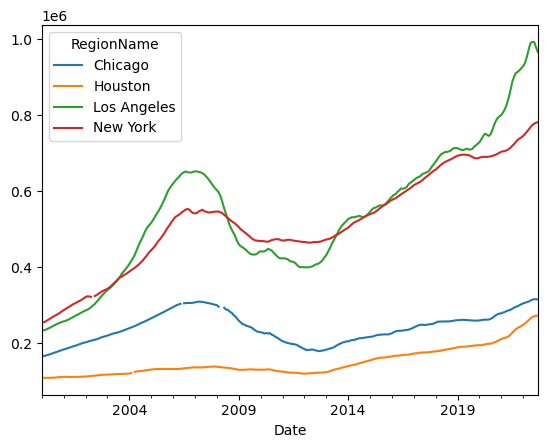

In [ ]:
ax= unstacked.plot()

In [ ]:
# GRIDSEARCH

ny = unstacked['New York']

ny = ny.loc['2018':]
ny

Date
2018-01-31    656700.0
2018-02-28    661012.0
2018-03-31    665672.0
2018-04-30    669989.0
2018-05-31    673514.0
2018-06-30    676434.0
2018-07-31    678984.0
2018-08-31    681140.0
2018-09-30    683546.0
2018-10-31    685588.0
2018-11-30    688553.0
2018-12-31    691226.0
2019-01-31    693208.0
2019-02-28    694425.0
2019-03-31    695720.0
2019-04-30    695824.0
2019-05-31    696173.0
2019-06-30    695186.0
2019-07-31    695010.0
2019-08-31    692926.0
2019-09-30    690189.0
2019-10-31    687693.0
2019-11-30    686304.0
2019-12-31    686650.0
2020-01-31    688073.0
2020-02-29    689697.0
2020-03-31    690055.0
2020-04-30    690520.0
2020-05-31    689921.0
2020-06-30    690785.0
2020-07-31    691384.0
2020-08-31    693097.0
2020-09-30    694261.0
2020-10-31    696260.0
2020-11-30    698929.0
2020-12-31    701899.0
2021-01-31    703956.0
2021-02-28    705003.0
2021-03-31    706066.0
2021-04-30    707633.0
2021-05-31    710706.0
2021-06-30    714507.0
2021-07-31    719155.0
2021-0

In [ ]:
# ny= ny.drop(['Chicago','Houston','Los Angeles'], axis=1)
# ny

In [ ]:
ny.isna().sum()

0

In [ ]:
ny= ny.interpolate()

<Axes: xlabel='Date'>

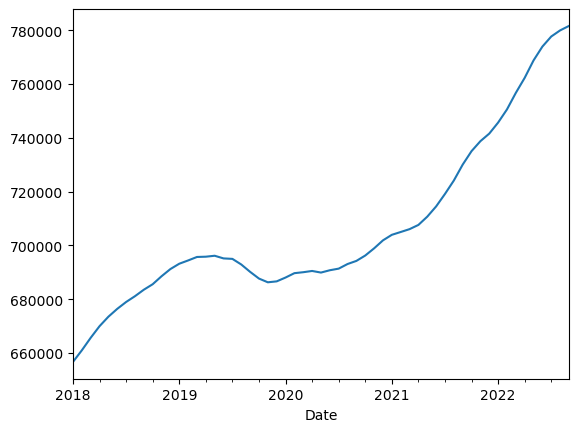

In [ ]:
#ny= ny.loc['2018':]
ny.plot()

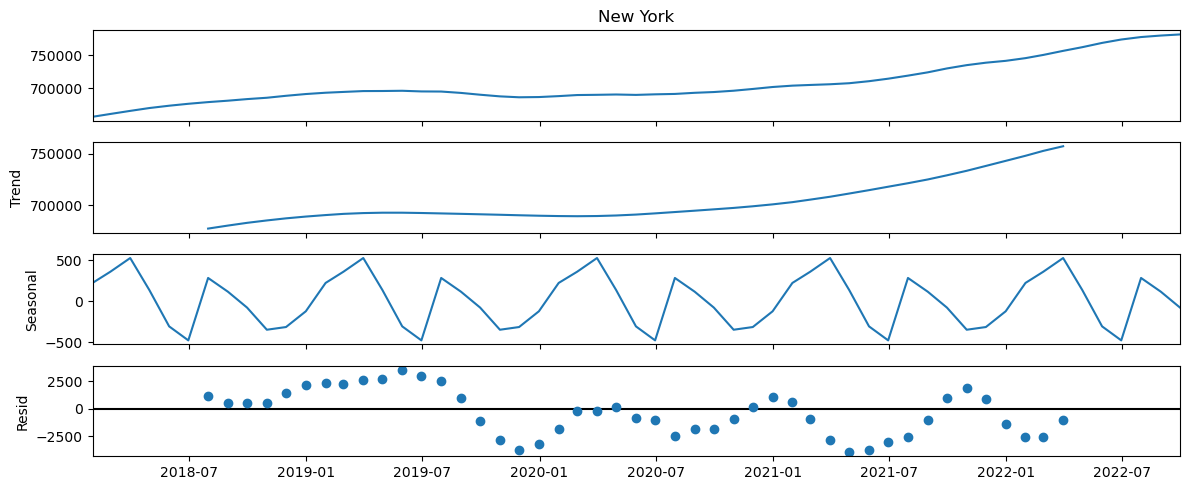

In [ ]:
import statsmodels.tsa.api as tsa
import matplotlib.pyplot as plt
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs
import pmdarima as pm

decomp = tsa.seasonal_decompose(ny)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

In [ ]:
ndiffs(ny)

2

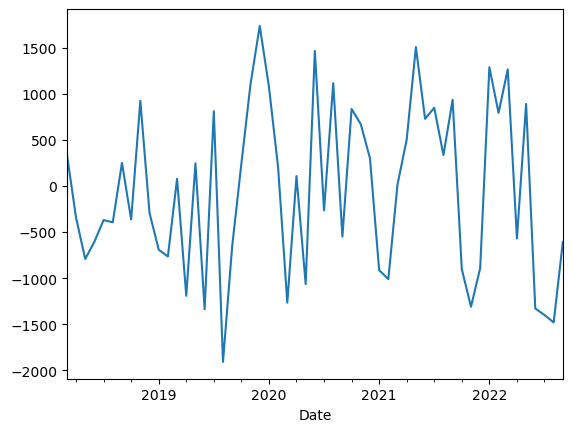

In [ ]:
ny_diff = ny.diff().diff().dropna()
ny_diff.plot();

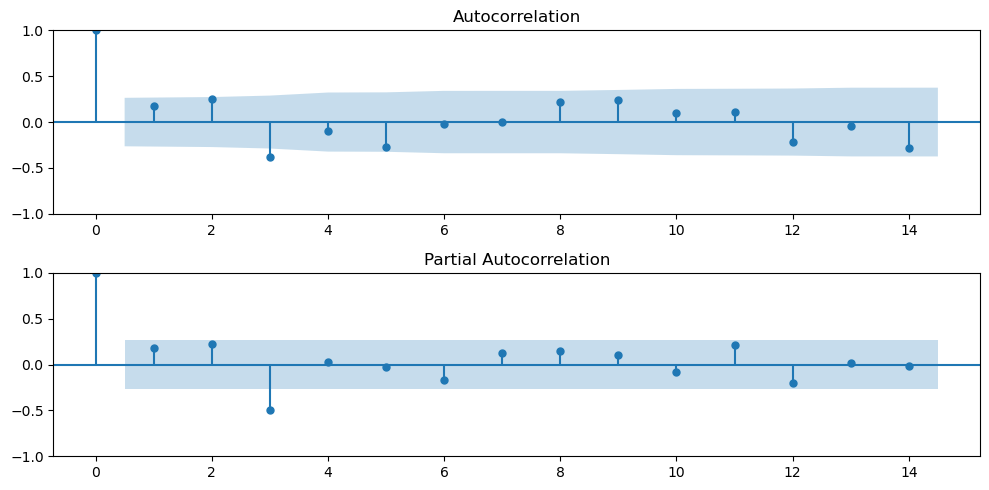

In [ ]:
plot_acf_pacf(ny_diff, nlags = 14);

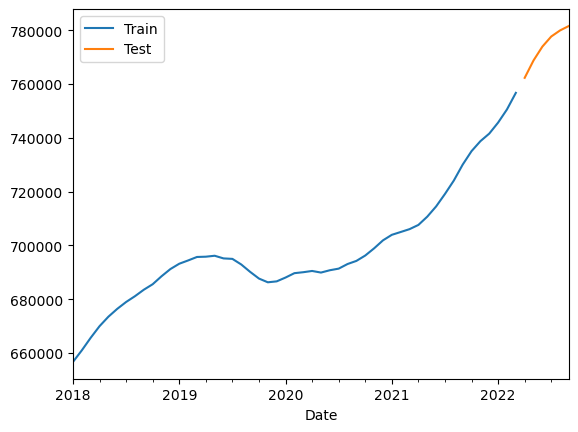

In [ ]:
train, test = train_test_split(ny, test_size=6)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

# Sofia, try fitting an arima model without the seasonal orders first because if you would check for how big the seasonal component is, it is less than 1% of the variation in the time series.

In [ ]:
# Fitting a SARIMA model

# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 6 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:
# What is the predicted home value in New York City 6 months into the future (beyond the dataset)?
# What is the percent change in home values in New York City by the end of the 6-month forecast (beyond the dataset)?